* Reference: __Enhancing a Pairs Trading strategy with the application of Machine Learning__ _by_ Simão Moraes Sarmento and Nuno Horta


In [1]:
from IPython.display import Image
import pandas as pd
import arbitragelab as al
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Implementation of a Machine Learning based Pairs Selection Framework

## Abstract

In this paper[1], Horta and Sarmento propose a two-stage solution to applying machine learning to the problem of pairs trading. The first stage involves the application of a clustering algorithm to infer any meaningful clusters and using these groups to generate pairs that will be run through a selection process that will supply a list of pairs that comply with the conditions set. 

The second stage should start by training forecasting algorithms to predict the spreads of the selected pairs. Furthermore, decile-based and quintile-based thresholds should be collected to integrate the trading model. Having fitted the forecasting algorithms and obtained the two combinations for the thresholds, the model can be applied to the validation set. From the validation performance, the best threshold combination is selected. At this point, the model is finally ready to be applied on unseen data, from which the performance may be inferred.

## Introduction

This notebook will focus on the first stage, which refers to the pairs selection methodology. It will involve the application of PCA to distill the returns universe into a lower dimensional form. Then the OPTICS algorithm will be applied, on the expectation that it infers meaningful clusters of assets from which to select the pairs. The motivation is to let the data explicitly manifest itself, rather than manually defining the groups each security should belong to. The proposed methodology encompasses the following steps:

- Dimensionality reduction - find a compact representation for each security;
- Unsupervised Learning - apply an appropriate clustering algorithm;
- Select pairs - define a set of rules to select pairs for trading.

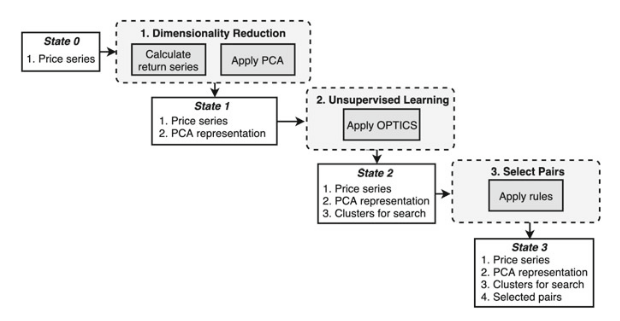

In [2]:
Image(filename='images/prposed_framework_diagram.png') 

---

# Usage of Implementation

To start using this module we first need to set up our asset universe, in this case, the dataset used is the daily price data of every asset in the S&P 500.

In [3]:
prices_df = pd.read_csv('./data/data.csv').set_index('Date').dropna()
prices_df.index = pd.to_datetime(prices_df.index)

prices_df = prices_df.last('10Y')

prices_df.sample(10)

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-29,70.699997,26.320000,138.070007,52.252499,66.220001,81.910004,192.009995,84.820000,198.740005,286.630005,...,103.449997,68.430000,52.020000,28.790001,76.389999,117.309998,138.179993,208.490005,40.770000,126.680000
2018-04-04,65.449997,52.040001,114.480003,42.902500,92.940002,86.250000,288.529999,59.459999,149.970001,225.050003,...,71.139999,74.870003,50.529999,28.309999,76.760002,85.419998,107.360001,139.479996,52.849998,82.849998
2016-07-26,46.950001,36.549999,166.229996,24.167500,64.449997,85.709999,114.269997,43.599998,114.260002,97.910004,...,49.700001,91.529999,63.070000,26.218708,47.779999,64.162476,123.620003,52.650002,26.590000,49.919998
2016-09-16,44.790001,35.490002,148.110001,28.730000,63.270000,84.110001,124.930000,41.869999,109.879997,98.930000,...,53.360001,84.029999,59.630001,25.823452,49.959999,63.292595,124.300003,67.260002,29.900000,50.509998
2016-04-21,41.930000,40.009998,157.130005,26.492500,61.369999,91.830002,102.120003,43.880001,114.480003,96.370003,...,46.029999,86.790001,60.540001,29.407114,41.840000,58.734722,114.400002,64.699997,26.719999,48.439999
2017-06-07,60.630001,50.860001,130.619995,38.842499,68.750000,91.930000,142.059998,46.560001,126.550003,143.619995,...,67.870003,80.910004,63.599998,28.160000,53.459999,74.260002,124.349998,106.570000,40.459999,63.259998
2016-06-13,44.919998,31.799999,152.550003,24.334999,59.930000,76.410004,101.769997,37.860001,117.080002,96.959999,...,46.320000,90.589996,64.730003,25.981554,45.669998,59.360172,118.239998,55.400002,27.520000,46.189999
2018-06-27,61.139999,38.259998,134.380005,46.040001,91.510002,89.820000,410.640015,60.490002,155.339996,237.679993,...,64.489998,81.709999,43.959999,24.510000,66.400002,78.870003,110.059998,141.759995,53.049999,83.360001
2020-08-17,97.510002,12.620000,161.000000,114.607498,96.349998,103.419998,309.549988,100.709999,232.619995,451.579987,...,104.639999,42.639999,43.680000,18.110001,79.220001,93.599998,138.580002,286.739990,33.880001,157.419998


## Step 1 - Dimensionality Reduction



### Using PCA to find a compact representation for each security

- Extracts common underlying risk factors from securities’ returns;
- Produces a compact representation for each security;

Before applying PCA, the pricing data needs to be converted to returns and then normalized by subtracting the mean and dividing by the standard deviation, as follows:

Returns 

$$ R_{i, t} = \frac{P_{i,t} - P_{i,t-1}} {P_{i,t-1}} $$


Data Normalization

$$ Y_{i} =  \frac{R_{i} - \bar{R_{i}}} {\sigma_{i}} $$

Decomposition

By applying PCA, $A$ is decomposed into the resulting eigenvectors and eigenvalues. An $n$ number of eigenvectors is selected where $n$ represents the number of features to describe the transformed data. The matrix containing the eigenvalues is set as the feature vector. The final dataset is obtained by multiplying the original matrix A by the feature vector.

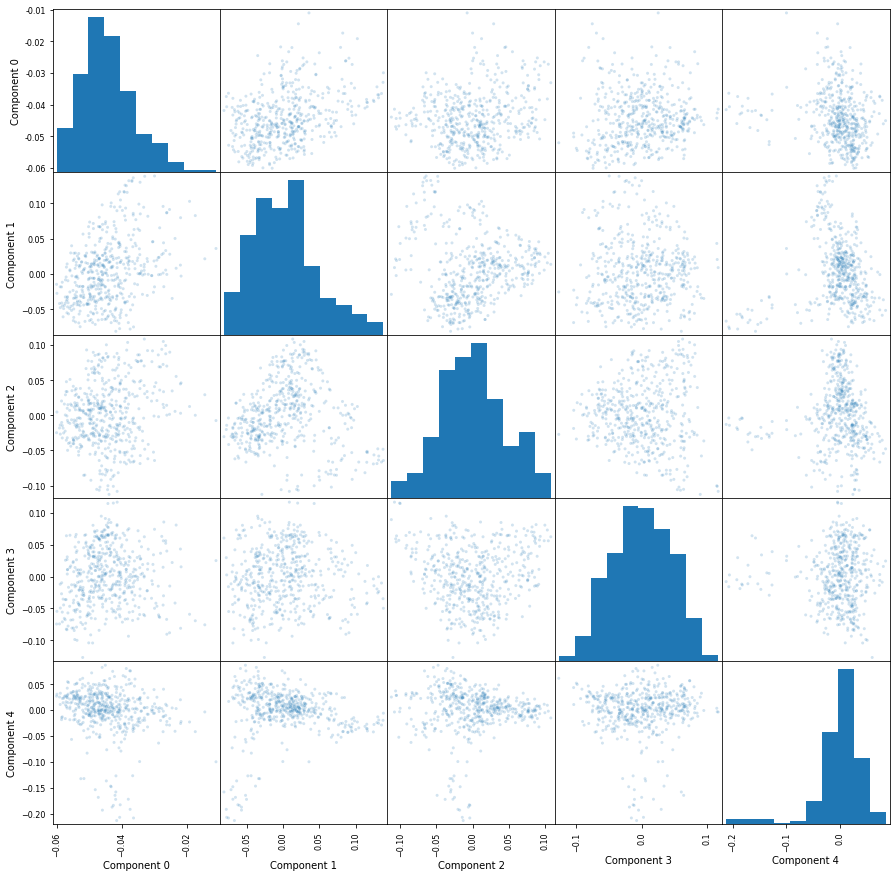

In [4]:
ps = al.ml_approach.OPTICSDBSCANPairsClustering(prices_df)

# Here the first parameter is the number of features to reduce to.
ps.dimensionality_reduction_by_components(5)

# The following will plot the feature vector from the previous method call.
ps.plot_pca_matrix();

A quick visual inspection of the feature vector shows a good amount of densely packed groups/clusters. If the points are too sparse, this likely suggests that you don't have enough datapoints.

## Step 2 - Unsupervised Learning
### Applying OPTICS clustering algorithm

- No need to specify the number of clusters in advance;
- Robust to outliers;
- Suitable for clusters with varying density


The first method is to use the OPTICS clustering algorithm and letting the built-in automatic 
procedure to select the most suitable $\epsilon$ for each cluster. 

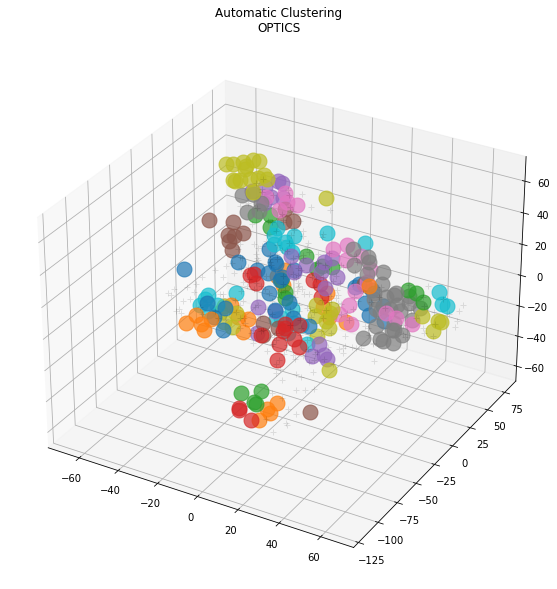

In [5]:
%matplotlib inline

clustered_pairs = ps.cluster_using_optics(min_samples=3)
ps.plot_clustering_info(method='OPTICS', n_dimensions=3);

### Applying DBSCAN clustering algorithm

The second method is to use the DBSCAN clustering algorithm. This is to be used when the user 
has domain-specific knowledge that can enhance the results given the algorithm's parameter 
sensitivity. A possible approach to finding $\epsilon$ described in [2] is to inspect the knee plot and fix a 
suitable $\epsilon$ by observing the global curve turning point.

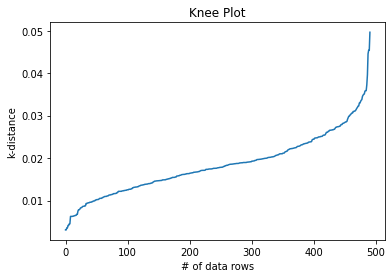

In [6]:
ps.plot_knee_plot();

The following are example results of DBSCAN clustering using different $\epsilon$ values, showing the efficacy of the method at different _'k-distance'_ values from the knee plot. 

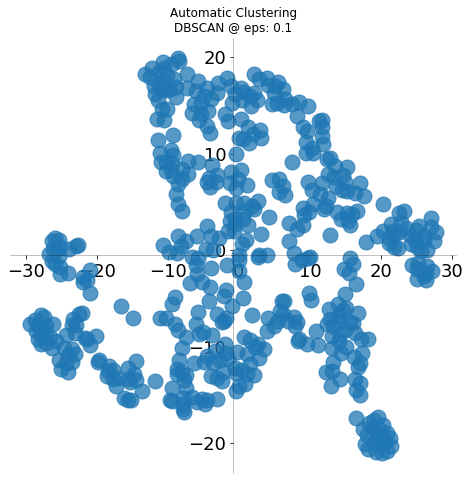

----------------------------------------------------------------------------------------------------


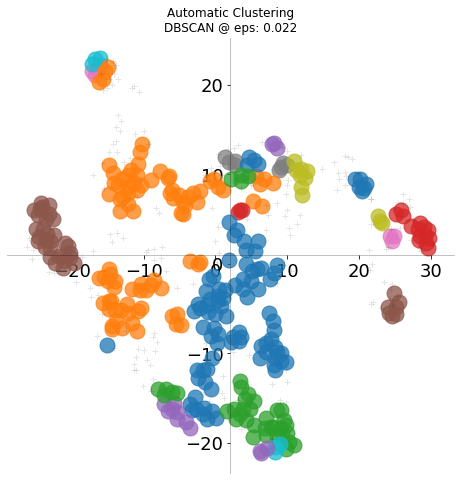

----------------------------------------------------------------------------------------------------


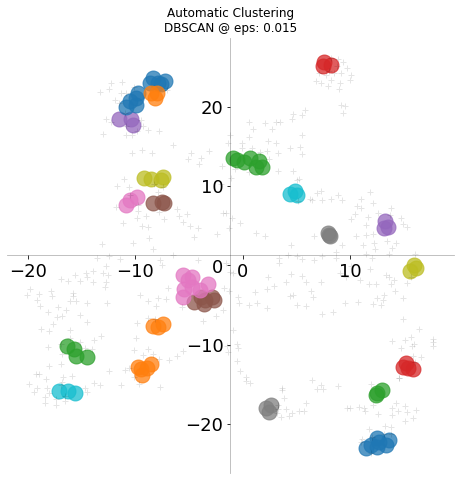

In [7]:
ps.cluster_using_dbscan(eps=0.1, min_samples=3, metric='euclidean')
ps.plot_clustering_info(method='DBSCAN @ eps: 0.1', figsize=(8,8));

print('-' * 100)

ps.cluster_using_dbscan(eps=0.022, min_samples=3, metric='euclidean')
ps.plot_clustering_info(method='DBSCAN @ eps: 0.022', figsize=(8,8));

print('-' * 100)

ps.cluster_using_dbscan(eps=0.015, min_samples=3, metric='euclidean')
ps.plot_clustering_info(method='DBSCAN @ eps: 0.015', figsize=(8,8));

The first plot shows the results with the upper bound value of 0.1, which was not sensitive enough to detect any groups. The second plot was set with the optimal value from the knee plot of 0.022 which detected a good amount of structure. The final plot was set with lower bound value of 0.015, which only managed to detect very densely packed clusters. 

## Step 3 - Select Pairs
### Finding resulting pairs that pass the following set of rules

Sarmento and Horta suggest four criteria to further filter the potential pairs to increase the probability of selecting pairs of securities whose prices will continue to mean revert in the future. 
- Cointegration using the Engle-Granger Test. 
- Hurst Exponent $H$: Keep the pairs with (spread) $H<0.5$ for mean-reversion. 
- Halflife: Keep the pairs with (spread) halflife in between $1$ day and $1$ year.
- Minimum number of crossing mean in a year: Keep the pairs with (spread) crossing its mean $12$ times a year.


These four criteria indicate attractive characteristics for potential tradable pairs of securities. The Engle-Granger tests the pair for cointegration. A Hurst exponent below 0.5 indicates that the pair of prices regresses strongly to the mean. Pairs with extreme half-life values, below 1 or above 356, are excluded from the selected pairs. Extreme half-life values indicate a price series that either reverts too quickly or too slowly to be traded. Finally, the price series must cross the long-term spread mean on average at least 12 times a year.

<div class="alert alert-warning">

**Warning:** The following pairs selection function is computationally heavy, so execution is going to be long and might slow down your system.

</div>


In [10]:
# Removing duplicates from clustered pairs
clustered_pairs = list(set(clustered_pairs))

In [11]:
# Load data into spread selector
sp = al.spread_selection.CointegrationSpreadSelector(prices_df=prices_df,
                                                     baskets_to_filter=clustered_pairs)
                                                    

# Filtered spreads that passed the criteria by specifying hedge ratio calculation method as well as filtering conditions.
filtered_spreads = sp.select_spreads()

Spread construction: |██████████████████████████████████████████████████| 100.0% Complete
Statistics generation: |██████████████████████████████████████████████████| 100.0% Complete


In [12]:
# The module can also work with user-specified spreads to test if a spread passes cointegration selection criterion.
spread = sp.spreads_dict['AAL_FTI'].copy() # Let's take an arbitrary spread.
pairs_selector_custom = al.spread_selection.CointegrationSpreadSelector(prices_df=None, baskets_to_filter=None)
stats = pairs_selector_custom.generate_spread_statistics(spread, log_info=True) # log_info=True to save stats.
print(stats)

{'coint_t': -3.311782004963325, 'p_value_99%': -3.435621806786881, 'p_value_95%': -2.8638680226791444, 'p_value_90%': -2.5680094689100477, 'hurst_exponent': 0.38669280381361, 'half_life': 39.716464348315284, 'crossovers': 63}


In [13]:
filtered_spreads_custom = pairs_selector_custom.apply_filtering_rules(adf_cutoff_threshold=0.9, hurst_exp_threshold=0.5)
print(filtered_spreads_custom)

['AAL_FTI']


In [14]:
# Checking the resulting spreads
filtered_spreads

array(['AAL_FTI', 'AAL_IVZ', 'AAL_TPR', ..., 'WMB_WRK', 'WMB_ZBH',
       'WMB_ZION'], dtype=object)

In [15]:
len(filtered_spreads)

1643

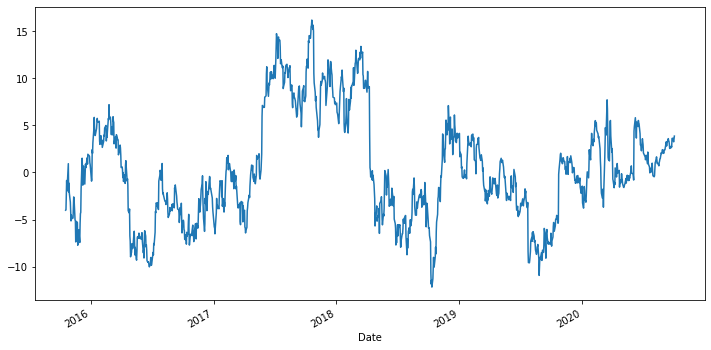

In [16]:
# Plot one of the spreads
sp.spreads_dict['AAL_FTI'].plot(figsize=(12,6));

In [17]:
# The following detailed spread statistics can be obtained
sp.selection_logs.loc[['AAL_FTI']].T

,AAL_FTI
coint_t,-3.31178
p_value_99%,-3.43562
p_value_95%,-2.86387
p_value_90%,-2.56801
hurst_exponent,0.386693
half_life,39.7165
crossovers,63
hedge_ratio,"{'AAL': 1.0, 'FTI': 1.431598178994171}"


---

# Conclusion

This notebook describes the proposed Pairs Selection Framework also shows example usage of the implemented framework to efficiently reduce the search space and select quality trading pairs. 

- Ten years of daily stock price data for 400 securities were reduced to 5 dimensions through PCA. 
- 1643 spreads from the clusters met the four selection criteria. 

Key takeaways:
- The number of pairs left for a trader to handle is much less compared to the number of pairs generated through an open combinatorial search of the whole asset universe.
- (Based on the previous research) Most of the final pairs selected follow expected economic sectoral clusters even though there was no implied industry/sectoral grouping anywhere in the framework.

Solutions to common pitfalls:
- Dimensionality reduction techniques need a certain amount of data to work reliably, so if instability is encountered at this junction, it is suggested to increase the amount of data.
- The number of PCA components needs to balance the amount of variance represented with density in euclidean distance. The rule of thumb is a number less than 15 components.
- When in doubt use OPTICS.
- For the clustering methods, the _'minimum samples'_ argument needs to be large enough so that the generated clusters are homogeneous. The rule of thumb is a number larger than 3.

# References
1. Sarmento, Simão. & Horta, Nuno. (2020). Enhancing a Pairs Trading strategy with the application of Machine Learning. Available at: http://premio-vidigal.inesc.pt/pdf/SimaoSarmentoMSc-resumo.pdf

2. Rahmah N, Sitanggang S (2016). Determination of Optimal Epsilon (Eps) Value on DBSCAN Algorithm to Clustering Data on Peatland Hotspots in Sumatra. Available at: https://doi.org/10.1088/1755-1315/31/1/012012